In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda:0")

cn_model_id = r"/datalake/homes/u_1401_00217454_x/.cache/torch/hub/checkpoints/genai/sd-controlnet-canny"
sd_model_id = r"/datalake/homes/u_1401_00217454_x/.cache/torch/hub/checkpoints/genai/stable-diffusion-v1-5"
#sd_model_id = r"/datalake/homes/u_1401_00217454_x/.cache/torch/hub/checkpoints/genai/stable-diffusion-2-base"

def canny_edge(image):
        
    image = np.array(image)

    low_threshold = 50
    high_threshold = 200

    image = cv2.Canny(image, low_threshold, high_threshold)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    canny_image = Image.fromarray(image)

    return canny_image

In [2]:
import torch
import numpy as np
from diffusers import ControlNetModel, StableDiffusionControlNetInpaintPipeline
from diffusers.utils import load_image, make_image_grid

cn_inpaint_model_id = r"/datalake/homes/u_1401_00217454_x/.cache/torch/hub/checkpoints/genai/controlnet_inpaint_main"
sd_inpaint_model_id = r"/datalake/homes/u_1401_00217454_x/.cache/torch/hub/checkpoints/genai/stable-diffusion-inpainting"
# load ControlNet
controlnet = ControlNetModel.from_pretrained(cn_inpaint_model_id, torch_dtype=torch.float16, variant="fp16")

# pass ControlNet to the pipeline
pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
           sd_inpaint_model_id, controlnet=controlnet, torch_dtype=torch.float16, variant="fp16")

pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
#pipeline.enable_xformers_memory_efficient_attention()

/datalake/WMLA/installation/W_Anaconda4Sigs/ana-1401-00217454/anaconda/envs/gai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|█████████████| 7/7 [00:11<00:00,  1.60s/it]


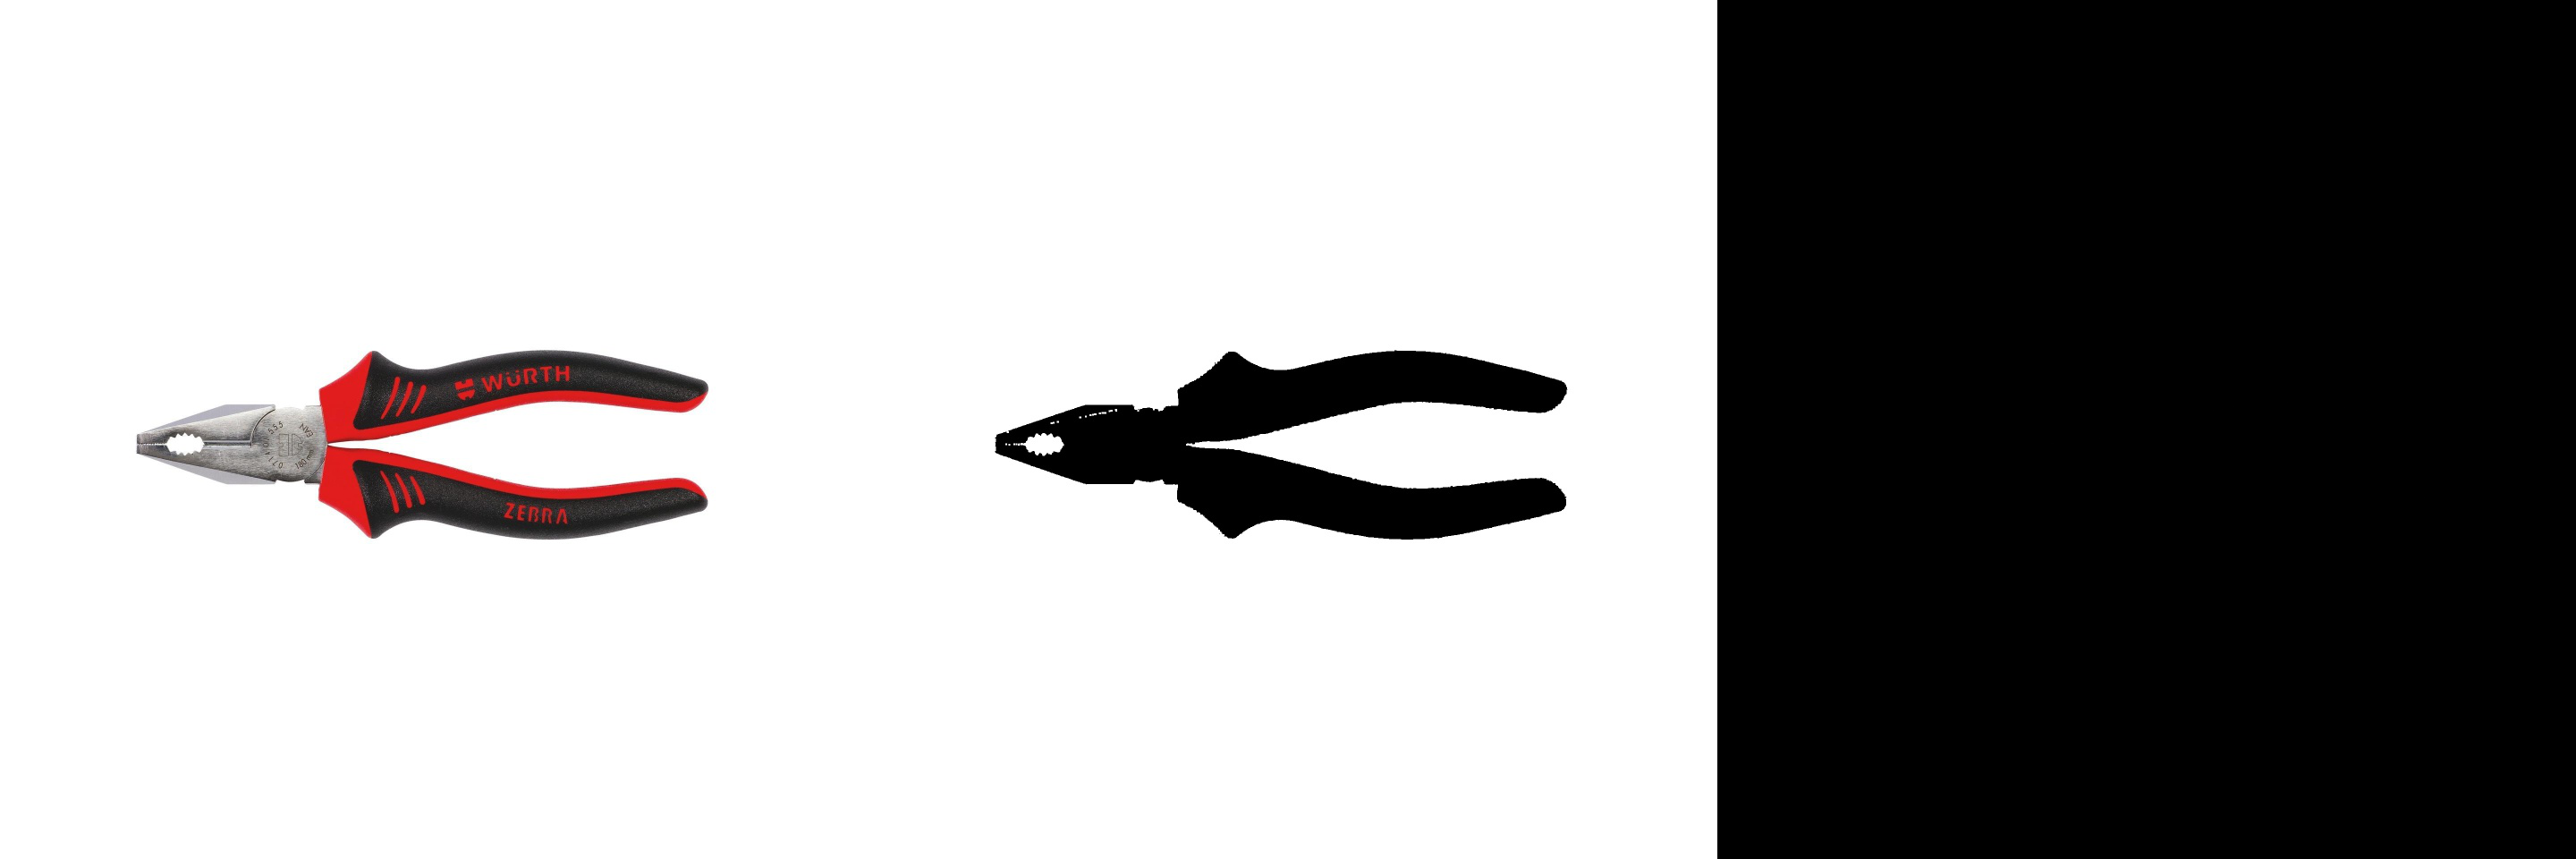

In [10]:
init_image = load_image("/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/141874.jpg")
init_image = load_image("/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/new_set/test_set/1271810.jpg")
image_path = r"/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/test_mask_new/small/141874.jpg"
mask_path = r"/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/test_mask_new/small/141874_mask.jpg"

mask_image = load_image("/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/141874_mask.png")
mask_image = load_image("/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/141874_mask.jpg")
mask_image = load_image("/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/141874_mask_latest_new.png")
#mask_image = load_image("/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/141874_mask_latestec.png")
mask_image = load_image("/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/new_set/test_set/1271810_mask.jpg")
mask_image = load_image("/datalake/WMLA/data/d_1401/projects/d_00217454/data/dev/in/gen_images/test_mask_new/small/141874_mask.jpg")
init_image = load_image(image_path)
mask_image = load_image(mask_path)

# prepare control image
def make_inpaint_condition(init_image, mask_image):
    init_image = np.array(init_image.convert("RGB")).astype(np.float32) / 255.0
    mask_image = np.array(mask_image.convert("L")).astype(np.float32) / 255.0

    assert init_image.shape[0:1] == mask_image.shape[0:1], "image and image_mask must have the same image size"
    init_image[mask_image > 0.05] = -1.0  # set as masked pixel
    init_image = np.expand_dims(init_image, 0).transpose(0, 3, 1, 2)
    init_image = torch.from_numpy(init_image)
    return init_image

def save_images(prompt, images, count):
    is_saved = False
    paths = []
    if isinstance(images, Image.Image):
        images.save(prompt + str(count + 1) + ".png")
        is_saved = True
        paths = prompt + str(count + 1) + ".png"
        
    elif isinstance(images, list):
        for img in images:
            count += 1
            img.save(prompt + str(count + 1) + ".png")
            paths.append([prompt + str(count + 1) + ".png"])
        is_saved = True
    
    if is_saved:
        print("The image(s) is / are saved successfully on the following path (s)... \n", paths)


control_image = make_inpaint_condition(init_image, mask_image)
make_image_grid([init_image, mask_image, Image.fromarray(np.uint8(control_image[0][0])).convert('RGB')], rows=1, cols=3)

In [11]:
control_image.shape

torch.Size([1, 3, 960, 960])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


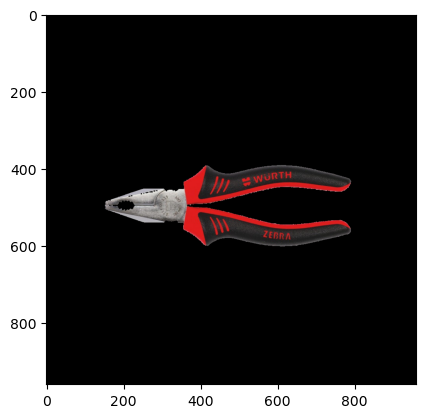

In [12]:
count = 0
plt.imshow(np.transpose(control_image[0], (1, 2, 0)))

In [14]:
prompt = "Wooden surface in the background with shadows"
prompt = "wooden surface in the background with dark shadows"
#prompt = "Mask placed on a brown surface with light coming from the left corner"
#prompt = "Shadow behind object, no other object, wooden surface, table, no noisy effects"
#prompt = "sharp wooden surface in the background of plier  while preserving the dimensions of the object"
negative_prompt="Edges of object are not dark, no shadow effects, no shadow, black excessive shadow, different shape, exceeds mask"
negative_prompt="Edges of object are not dark, no shadows"
image_name = image_path.split("/")[-1]

#negative_prompt = "Things other than wood,transformations, complex things, unusual mixing or placements."
# negative_prompt=negative_prompt
#mage = pipeline(prompt=prompt, image=init_image, negative_prompt=negative_prompt, mask_image=mask_image, control_image=control_image, num_inference_steps = 80).images[0]
image = pipeline(prompt=prompt, image=init_image, negative_prompt=negative_prompt, mask_image=mask_image, control_image=control_image, num_inference_steps = 100, num_images_per_prompt = 10, guidance_scale=7).images
#image = pipeline(prompt=prompt, image=init_image, negative_prompt=negative_prompt, mask_image=mask_image, control_image=control_image, num_images_per_prompt = 5).images
save_images(prompt + image_name, image, count)

count += 6

#make_image_grid([init_image, mask_image, Image.fromarray(np.transpose(control_image[0], (1, 2, 0))), image], rows=2, cols=2)
make_image_grid([image[0], image[1], image[2], image[3]], rows=2, cols=2)

100%|█████████████████████████████████████████| 100/100 [06:30<00:00,  3.91s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 2.20 GiB (GPU 0; 31.75 GiB total capacity; 23.00 GiB already allocated; 470.88 MiB free; 30.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
pwd

'/datalake/homes/u_1401_00217454_x'

In [ ]:
make_image_grid([image[4]], rows=1, cols=1)

In [ ]:
image[4]

In [ ]:
image[0] is list

In [ ]:
image is list()

In [ ]:
image

In [ ]:
save(prompt, image, count)

In [ ]:
def save_images(prompt, images, count):
    is_saved = False
    paths = []
    if isinstance(images, Image.Image):
        images.save(prompt + str(count + 1) + ".png")
        is_saved = True
        paths = prompt + str(count + 1) + ".png"
        
    elif isinstance(images, list):
        for img in images:
            count += 1
            img.save(prompt + str(count + 1) + ".png")
            paths.append([prompt + str(count + 1) + ".png"])
        is_saved = True
    
    if is_saved:
        print("The image(s) is / are saved successfully on the following path (s)... \n", paths)